Importing libraries

In [1]:
import os
from astropy.io import fits
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
from keras.preprocessing.image import ImageDataGenerator
import random

Setting up GPUs

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Setting up AlexNet

In [3]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [25]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(6,6), strides=(6,6), activation='relu', input_shape=(127,127,5)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(4,4), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
    ])

model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 21, 21, 96)        17376     
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 21, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 256)       393472    
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 384)       

GridSearch

In [38]:
from sklearn.model_selection import GridSearchCV

def create_model(pool_sizes = 3,stride_size = 2):
    
    model = Sequential()
    
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(6,6), strides=(6,6), activation='relu', input_shape=(127,127,5)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(pool_sizes,pool_sizes), strides=(stride_size,stride_size)))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    return model

model_CV = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model,epochs = 100, shuffle = True, verbose = 0)

stride_size = [1,2,3,4]
pool_sizes = [1,2,3,4]
param_grid = dict(stride_size = stride_size,pool_sizes = pool_sizes)
grid = GridSearchCV(estimator=model_CV,param_grid = param_grid, scoring = "neg_mean_absolute_error",cv=3)
grid_result = grid.fit(x_train, y_train)
grid_result

/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/keras/engine/training.py", line 1158, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/opt/anaconda3/envs/jupyterhu

/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/keras/engine/training.py", line 1158, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/opt/anaconda3/envs/jupyterhu

KeyboardInterrupt: 

In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.256676 using {'stride_size': 6}
-0.267129 (0.013140) with: {'stride_size': 5}
-0.256676 (0.019207) with: {'stride_size': 6}
-0.264485 (0.002286) with: {'stride_size': 7}
-0.268365 (0.004802) with: {'stride_size': 8}


In [4]:
hf = h5py.File('../../data/HSC/HSC_v6/five_band_image127x127.hdf5', 'r')

In [26]:
history_all = []
for i in range(20):
    index = np.array(random.sample(range(0,229120),1000))
    index.sort()
    x = []
    y = []
    
    #normalization through all images
    #raw_image = hf["image"][index]
    #label = hf["specz"][index]
    #raw_image = np.transpose(raw_image,(0,2,3,1))
    #log_image = np.log(raw_image+14.2354765) #the minimum of pixel value is -13.2354765.
    #x = np.true_divide(log_image,6.331177841002785)
    #y = label
    
    
    #normalization per batch
    #raw_image = hf["image"][index]
    #label = hf["specz"][index]
    #raw_image = np.transpose(raw_image,(0,2,3,1))
    #image_min = np.min(raw_image)
    #log_image = np.log(raw_image-image_min+1)
    #x = np.true_divide(log_image,(np.max(log_image)))
    #y = label
    
    #normalization per image 
    for j in index:
        
        raw_image = hf["image"][j]
        label = hf["specz"][j]
        raw_image = np.transpose(raw_image,(1,2,0))
        image_min = np.min(raw_image)
        rescale_image = raw_image+np.full((127,127,5),1-image_min)
        log_image = np.log(rescale_image)
        norm_image = np.true_divide(log_image,(np.max(log_image)))
        x.append(norm_image)
        y.append(label)
    
    x_train = np.array(x)
    y_train = np.array(y)
    
    #image augmentation
    
    #datagen = ImageDataGenerator(rotation_range=180)
    #datagen.fit(x_train)

    history = model.fit(x_train, y_train,epochs=40,shuffle = True,verbose=1)
    history_all.append(history)



Epoch 1/40
32/32 [==============================] - 2s 8ms/step - loss: 117.4397 - mean_absolute_error: 8.0001
Epoch 2/40
32/32 [==============================] - 0s 7ms/step - loss: 0.3067 - mean_absolute_error: 2.1894
Epoch 3/40
32/32 [==============================] - 0s 8ms/step - loss: 0.2005 - mean_absolute_error: 1.3498
Epoch 4/40
32/32 [==============================] - 0s 8ms/step - loss: 0.2173 - mean_absolute_error: 1.0242
Epoch 5/40
32/32 [==============================] - 0s 8ms/step - loss: 0.2290 - mean_absolute_error: 0.8540
Epoch 6/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1952 - mean_absolute_error: 0.7444
Epoch 7/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1572 - mean_absolute_error: 0.6689
Epoch 8/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1811 - mean_absolute_error: 0.6149
Epoch 9/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1413 - mean_absolute_error: 0.5708
Epoch 10/40
32/32

32/32 [==============================] - 0s 7ms/step - loss: 0.1011 - mean_absolute_error: 0.2454
Epoch 36/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0724 - mean_absolute_error: 0.2444
Epoch 37/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0691 - mean_absolute_error: 0.2432
Epoch 38/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0809 - mean_absolute_error: 0.2421
Epoch 39/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0849 - mean_absolute_error: 0.2412
Epoch 40/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0668 - mean_absolute_error: 0.2401
Epoch 1/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1770 - mean_absolute_error: 0.2394
Epoch 2/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1542 - mean_absolute_error: 0.2393
Epoch 3/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1509 - mean_absolute_error: 0.2390
Epoch 4/40
32/32 [=======

32/32 [==============================] - 0s 8ms/step - loss: 0.0904 - mean_absolute_error: 0.2177
Epoch 30/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0837 - mean_absolute_error: 0.2174
Epoch 31/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0952 - mean_absolute_error: 0.2171
Epoch 32/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0922 - mean_absolute_error: 0.2167
Epoch 33/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0902 - mean_absolute_error: 0.2164
Epoch 34/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0880 - mean_absolute_error: 0.2161
Epoch 35/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0782 - mean_absolute_error: 0.2157
Epoch 36/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0959 - mean_absolute_error: 0.2155
Epoch 37/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0734 - mean_absolute_error: 0.2151
Epoch 38/40
32/32 [===

32/32 [==============================] - 0s 8ms/step - loss: 0.1018 - mean_absolute_error: 0.1987
Epoch 24/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0983 - mean_absolute_error: 0.1987
Epoch 25/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0855 - mean_absolute_error: 0.1986
Epoch 26/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0632 - mean_absolute_error: 0.1984
Epoch 27/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0633 - mean_absolute_error: 0.1982
Epoch 28/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0597 - mean_absolute_error: 0.1980
Epoch 29/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0914 - mean_absolute_error: 0.1978
Epoch 30/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0631 - mean_absolute_error: 0.1977
Epoch 31/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0918 - mean_absolute_error: 0.1976
Epoch 32/40
32/32 [===

32/32 [==============================] - 0s 8ms/step - loss: 0.0961 - mean_absolute_error: 0.1952
Epoch 18/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0663 - mean_absolute_error: 0.1951
Epoch 19/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0675 - mean_absolute_error: 0.1950
Epoch 20/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0840 - mean_absolute_error: 0.1949
Epoch 21/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0719 - mean_absolute_error: 0.1949
Epoch 22/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0696 - mean_absolute_error: 0.1948
Epoch 23/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0647 - mean_absolute_error: 0.1947
Epoch 24/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0721 - mean_absolute_error: 0.1945
Epoch 25/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0728 - mean_absolute_error: 0.1944
Epoch 26/40
32/32 [===

32/32 [==============================] - 0s 8ms/step - loss: 0.1402 - mean_absolute_error: 0.1878
Epoch 12/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1576 - mean_absolute_error: 0.1879
Epoch 13/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1476 - mean_absolute_error: 0.1880
Epoch 14/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1322 - mean_absolute_error: 0.1881
Epoch 15/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1176 - mean_absolute_error: 0.1882
Epoch 16/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1178 - mean_absolute_error: 0.1883
Epoch 17/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1224 - mean_absolute_error: 0.1883
Epoch 18/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0967 - mean_absolute_error: 0.1883
Epoch 19/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1016 - mean_absolute_error: 0.1884
Epoch 20/40
32/32 [===

32/32 [==============================] - 0s 7ms/step - loss: 0.1021 - mean_absolute_error: 0.1875
Epoch 6/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1026 - mean_absolute_error: 0.1875
Epoch 7/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0911 - mean_absolute_error: 0.1875
Epoch 8/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0821 - mean_absolute_error: 0.1875
Epoch 9/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0755 - mean_absolute_error: 0.1875
Epoch 10/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0769 - mean_absolute_error: 0.1874
Epoch 11/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0713 - mean_absolute_error: 0.1874
Epoch 12/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0868 - mean_absolute_error: 0.1873
Epoch 13/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0746 - mean_absolute_error: 0.1873
Epoch 14/40
32/32 [=======

32/32 [==============================] - 0s 8ms/step - loss: 0.0280 - mean_absolute_error: 0.1831
Epoch 40/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0271 - mean_absolute_error: 0.1830
Epoch 1/40
32/32 [==============================] - 0s 7ms/step - loss: 0.1658 - mean_absolute_error: 0.1830
Epoch 2/40
32/32 [==============================] - 0s 7ms/step - loss: 0.1296 - mean_absolute_error: 0.1830
Epoch 3/40
32/32 [==============================] - 0s 7ms/step - loss: 0.1128 - mean_absolute_error: 0.1831
Epoch 4/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1177 - mean_absolute_error: 0.1831
Epoch 5/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1198 - mean_absolute_error: 0.1831
Epoch 6/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1102 - mean_absolute_error: 0.1831
Epoch 7/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0803 - mean_absolute_error: 0.1831
Epoch 8/40
32/32 [===========

32/32 [==============================] - 0s 8ms/step - loss: 0.0454 - mean_absolute_error: 0.1790
Epoch 34/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0394 - mean_absolute_error: 0.1789
Epoch 35/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0399 - mean_absolute_error: 0.1788
Epoch 36/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0411 - mean_absolute_error: 0.1787
Epoch 37/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0347 - mean_absolute_error: 0.1786
Epoch 38/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0575 - mean_absolute_error: 0.1785
Epoch 39/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0681 - mean_absolute_error: 0.1785
Epoch 40/40
32/32 [==============================] - 0s 7ms/step - loss: 0.0437 - mean_absolute_error: 0.1784
Epoch 1/40
32/32 [==============================] - 0s 8ms/step - loss: 0.1791 - mean_absolute_error: 0.1784
Epoch 2/40
32/32 [=====

32/32 [==============================] - 0s 8ms/step - loss: 0.0357 - mean_absolute_error: 0.1753
Epoch 28/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0315 - mean_absolute_error: 0.1753
Epoch 29/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0390 - mean_absolute_error: 0.1752
Epoch 30/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0392 - mean_absolute_error: 0.1751
Epoch 31/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0277 - mean_absolute_error: 0.1750
Epoch 32/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0243 - mean_absolute_error: 0.1749
Epoch 33/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0304 - mean_absolute_error: 0.1748
Epoch 34/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0285 - mean_absolute_error: 0.1747
Epoch 35/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0365 - mean_absolute_error: 0.1746
Epoch 36/40
32/32 [===

32/32 [==============================] - 0s 8ms/step - loss: 0.0394 - mean_absolute_error: 0.1720
Epoch 22/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0498 - mean_absolute_error: 0.1720
Epoch 23/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0359 - mean_absolute_error: 0.1719
Epoch 24/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0290 - mean_absolute_error: 0.1719
Epoch 25/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0378 - mean_absolute_error: 0.1718
Epoch 26/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0321 - mean_absolute_error: 0.1717
Epoch 27/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0422 - mean_absolute_error: 0.1716
Epoch 28/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0620 - mean_absolute_error: 0.1716
Epoch 29/40
32/32 [==============================] - 0s 8ms/step - loss: 0.0405 - mean_absolute_error: 0.1716
Epoch 30/40
32/32 [===

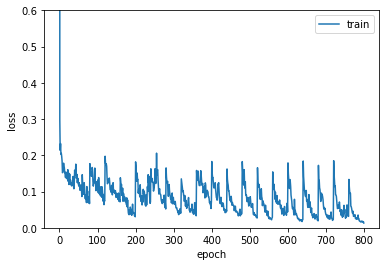

In [28]:
history_ = []
for i in range(len(history_all)):
    history_.append(history_all[i].history['loss'])

history_ = np.array(history_)
history_ = history_.reshape(800)
plt.plot(history_, label='train')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim([0,0.6])
plt.show()

In [33]:
x_test = []
y_test = []

#normalization through all images
#index = np.arange(242000,244000)
#raw_image_test = hf["image"][index]
#label_test = hf["specz"][index]
#raw_image_test = np.transpose(raw_image_test,(0,2,3,1))
#log_image_test = np.log(raw_image_test+14.2354765) #the minimum of pixel value is -13.2354765.
#x_test = np.true_divide(log_image_test,6.331177841002785)
#y_test = label_test

#normalization per batch


for i in range (244000,247000):
    raw_image = hf["image"][i]
    label = hf["specz"][i]
    raw_image = np.transpose(raw_image,(1,2,0))
    image_min = np.min(raw_image)
    log_image = np.log(raw_image-image_min+1)
    norm_image = np.true_divide(log_image,(np.max(log_image)))
    x_test.append(norm_image)
    y_test.append(label)       
    
x_test = np.array(x_test)
y_test = np.array(y_test)

In [34]:
y_test_predict = model.predict(x_test)
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(y_test_predict[i][0])

y_test_prediction = np.asarray(y_test_prediction)

y_test_ = []

for i in range(len(y_test)):
    y_test_.append(y_test[i][0])

y_test_ = np.asarray(y_test_)

In [35]:
from photoz_utils import *
y_test_new = pd.Series(y_test_)
y_test_predict_new = pd.Series(y_test_prediction)
get_point_metrics(y_test_predict_new,y_test_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",3000,0.377607,0.089876,0.088113,0.124474,0.117144,0.065,0.369,0.182772


In [36]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test_,y_test_prediction])
z = gaussian_kde(xy)(xy)

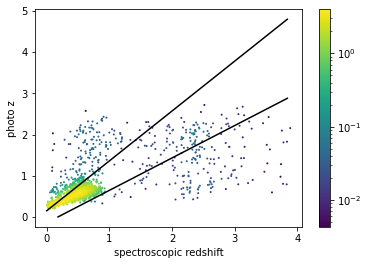

In [37]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(y_test, y_test_prediction, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')